In [34]:
import warnings
warnings.filterwarnings('ignore')


import os
import numpy as np
import pandas as pd
from pathlib import Path


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
classification_report, confusion_matrix, roc_auc_score, roc_curve,
precision_recall_curve, average_precision_score, f1_score
)
from sklearn.utils import resample


import matplotlib.pyplot as plt


RANDOM_STATE = 42

In [35]:
df = pd.read_csv('falhas.csv')

### BANCO DE DADOS

---



In [40]:
df.head(5)

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [38]:
print('Shape dos dados:', df.shape)
print('Colunas:', df.columns.tolist())

Shape dos dados: (10000, 14)
Colunas: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [39]:
df.head(5)


# Info e nulos
print(df.info())
print(df.isna().sum().sort_values(ascending=False).head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

ANÁLISE DAS INFORMAÇÕES

---



In [60]:
TARGET = 'Machine failure'
if TARGET not in df.columns:
    raise ValueError(f"Coluna alvo '{TARGET}' não encontrada.")

print('Distribuição do target:')
print(df[TARGET].value_counts(normalize=True))

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numéricas:', len(num_cols), '| Categóricas:', len(cat_cols))

Distribuição do target:
Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64
Numéricas: 11 | Categóricas: 2


### DIVISÃO DE TREINO E TESTE

---



In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)

print('Train:', X_train.shape, '| Test:', X_test.shape)


Train: (7500, 13) | Test: (2500, 13)


### ESCALONAMENTO DOS DADOS

---



In [62]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


preprocessor.fit(X_train)


X_train_trans = preprocessor.transform(X_train)
X_test_trans = preprocessor.transform(X_test)


In [63]:
train_data = pd.concat([X_train, y_train], axis=1)
major = train_data[train_data[TARGET] == 0]
minor = train_data[train_data[TARGET] == 1]

print('Tamanho treino original:')
print(train_data[TARGET].value_counts())

ratio_major_to_minor = 4
n_major_new = max(len(minor) * ratio_major_to_minor, 1)

major_down = resample(
    major,
    replace=False,
    n_samples=int(n_major_new),
    random_state=RANDOM_STATE
)

Tamanho treino original:
Machine failure
0    7246
1     254
Name: count, dtype: int64


In [64]:
train_bal = pd.concat([major_down, minor]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
X_train_bal = train_bal.drop(columns=[TARGET])
y_train_bal = train_bal[TARGET]


X_train_bal_trans = preprocessor.transform(X_train_bal)

print('Tamanho treino após undersampling:')
print(y_train_bal.value_counts())


Tamanho treino após undersampling:
Machine failure
0    1016
1     254
Name: count, dtype: int64


### BALANCEAMENTO DAS CLASSES

---



In [65]:
# Modelo A com class_weight balanceado
model_a = LogisticRegression(
    max_iter=2000, class_weight='balanced', solver='lbfgs', random_state=RANDOM_STATE
)

# Modelo B com undersample + regularização L1
model_b = LogisticRegression(
    max_iter=2000, penalty='l1', solver='liblinear', C=0.7, random_state=RANDOM_STATE
)


### TREINAMENTO DOS MODELOS

---



In [66]:
model_a.fit(X_train_trans, y_train)
model_b.fit(X_train_bal_trans, y_train_bal)

LogisticRegression(C=0.7, max_iter=2000, penalty='l1', random_state=42,
                   solver='liblinear')

### RESULTADOS

---



In [67]:
for name, model in [
    ('Modelo A (class_weight)', model_a),
    ('Modelo B (undersample + L1)', model_b)
]:
    y_pred = model.predict(X_test_trans)
    y_proba = model.predict_proba(X_test_trans)[:, 1]
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred, digits=4))
    print('ROC AUC:', roc_auc_score(y_test, y_proba))


--- Modelo A (class_weight) ---
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996      2415
           1     1.0000    0.9765    0.9881        85

    accuracy                         0.9992      2500
   macro avg     0.9996    0.9882    0.9938      2500
weighted avg     0.9992    0.9992    0.9992      2500

ROC AUC: 0.9771720862257947

--- Modelo B (undersample + L1) ---
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996      2415
           1     1.0000    0.9765    0.9881        85

    accuracy                         0.9992      2500
   macro avg     0.9996    0.9882    0.9938      2500
weighted avg     0.9992    0.9992    0.9992      2500

ROC AUC: 0.9787796857873584


In [68]:
y_pred_a = model_a.predict(X_test_trans)
y_pred_b = model_b.predict(X_test_trans)

diff_mask = y_pred_a != y_pred_b
print('\nPredições diferentes em', diff_mask.sum(), 'amostras de', len(y_test))

if diff_mask.sum() > 0:
    diffs = pd.DataFrame({
        'y_true': y_test.values,
        'pred_a': y_pred_a,
        'pred_b': y_pred_b,
        'prob_a': model_a.predict_proba(X_test_trans)[:,1],
        'prob_b': model_b.predict_proba(X_test_trans)[:,1]
    })
    display(diffs[diff_mask].head(20))



Predições diferentes em 0 amostras de 2500


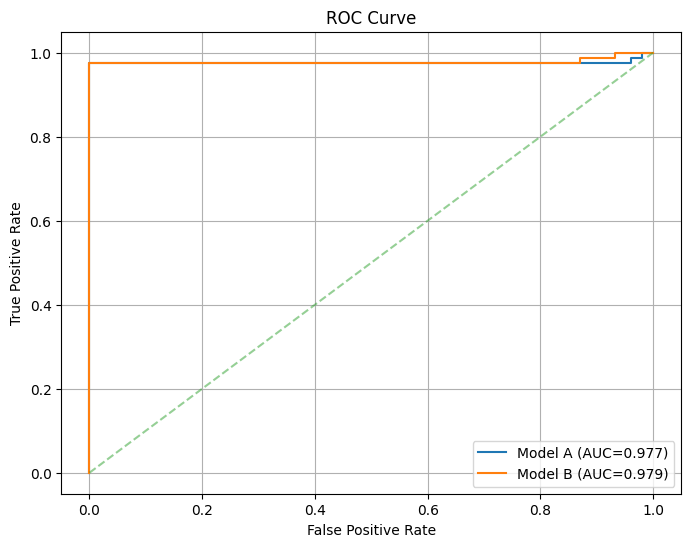

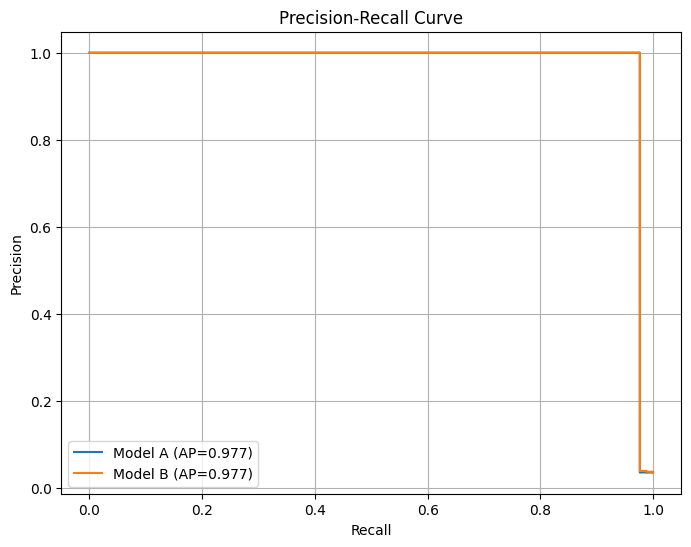

In [69]:
proba_a = model_a.predict_proba(X_test_trans)[:,1]
proba_b = model_b.predict_proba(X_test_trans)[:,1]


fpr_a, tpr_a, _ = roc_curve(y_test, proba_a)
fpr_b, tpr_b, _ = roc_curve(y_test, proba_b)

plt.figure(figsize=(8,6))
plt.plot(fpr_a, tpr_a, label=f'Model A (AUC={roc_auc_score(y_test, proba_a):.3f})')
plt.plot(fpr_b, tpr_b, label=f'Model B (AUC={roc_auc_score(y_test, proba_b):.3f})')
plt.plot([0,1],[0,1],'--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


precision_a, recall_a, _ = precision_recall_curve(y_test, proba_a)
precision_b, recall_b, _ = precision_recall_curve(y_test, proba_b)

ap_a = average_precision_score(y_test, proba_a)
ap_b = average_precision_score(y_test, proba_b)

plt.figure(figsize=(8,6))
plt.plot(recall_a, precision_a, label=f'Model A (AP={ap_a:.3f})')
plt.plot(recall_b, precision_b, label=f'Model B (AP={ap_b:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


### AJUSTE DO threshold

---




Melhor threshold (max F1): 0.025
F1 nesse threshold: 0.9880952380952381


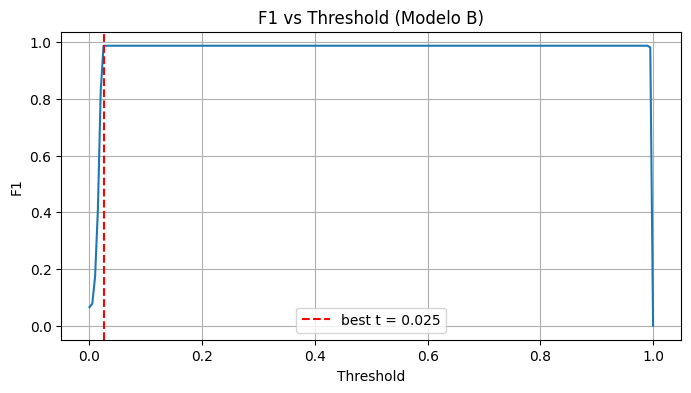

In [70]:
probs = proba_b
thresholds = np.linspace(0,1,201)
f1s = [f1_score(y_test, (probs>t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1s)]
print('\nMelhor threshold (max F1):', best_t)
print('F1 nesse threshold:', max(f1s))

plt.figure(figsize=(8,4))
plt.plot(thresholds, f1s)
plt.axvline(best_t, color='red', linestyle='--', label=f'best t = {best_t:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.title('F1 vs Threshold (Modelo B)')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
y_pred_b_tuned = (probs > best_t).astype(int)
print('\nRelatório Modelo B ajustado:')
print(classification_report(y_test, y_pred_b_tuned, digits=4))


Relatório Modelo B ajustado:
              precision    recall  f1-score   support

           0     0.9992    1.0000    0.9996      2415
           1     1.0000    0.9765    0.9881        85

    accuracy                         0.9992      2500
   macro avg     0.9996    0.9882    0.9938      2500
weighted avg     0.9992    0.9992    0.9992      2500



### DESEMPENHO DOS MODELOS

---



In [73]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_a = Pipeline(steps=[('preprocessor', preproc_base), ('classifier', model_a)])
pipeline_b = Pipeline(steps=[('preprocessor', preproc_base), ('classifier', model_b)])



scores_a = cross_val_score(pipeline_a, X, y, cv=cv, scoring='roc_auc')
scores_b = cross_val_score(pipeline_b, X, y, cv=cv, scoring='roc_auc')

print("=== Validação Cruzada (ROC AUC) ===")
print(f"Modelo A (class_weight): Média = {scores_a.mean():.4f}, Desvio = {scores_a.std():.4f}")
print(f"Modelo B (undersample + L1): Média = {scores_b.mean():.4f}, Desvio = {scores_b.std():.4f}")

=== Validação Cruzada (ROC AUC) ===
Modelo A (class_weight): Média = 0.9818, Desvio = 0.0046
Modelo B (undersample + L1): Média = 0.9820, Desvio = 0.0050


Dimensões de X_test: (2500, 13)
Dimensões de y_test: (2500,)


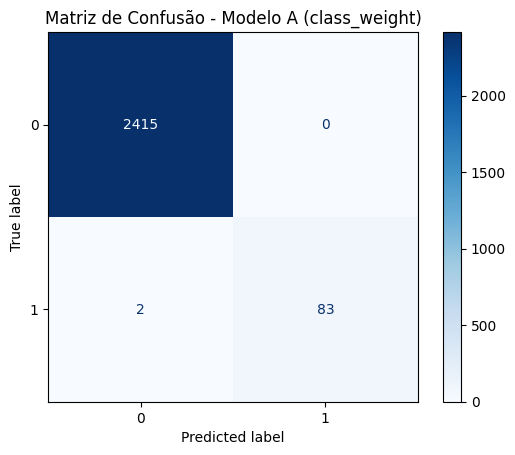

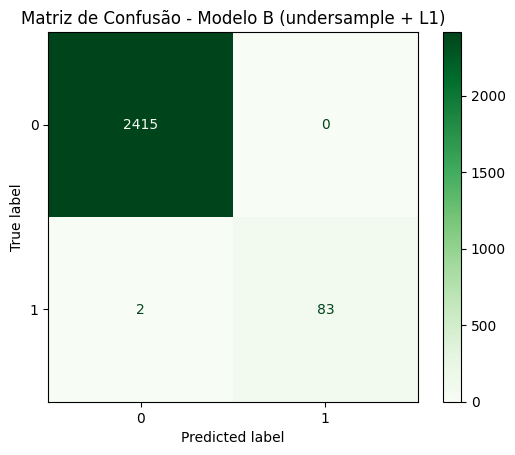

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("Dimensões de X_test:", X_test.shape)
print("Dimensões de y_test:", y_test.shape)


try:
    y_pred_a = model_a.predict(X_test)
except:
    y_pred_a = model_a.predict(X_test_trans)

cm_a = confusion_matrix(y_test, y_pred_a)
disp_a = ConfusionMatrixDisplay(confusion_matrix=cm_a)
disp_a.plot(cmap='Blues')
plt.title("Matriz de Confusão - Modelo A (class_weight)")
plt.show()


try:
    y_pred_b = model_b.predict(X_test)
except:
    y_pred_b = model_b.predict(X_test_trans)

cm_b = confusion_matrix(y_test, y_pred_b)
disp_b = ConfusionMatrixDisplay(confusion_matrix=cm_b)
disp_b.plot(cmap='Greens')
plt.title("Matriz de Confusão - Modelo B (undersample + L1)")
plt.show()
